# Metrics

- skip_exec: true


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score,
    auc,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0

## Prepare Example Model


In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")

In [ ]:
y = y.astype(int)

In [ ]:
categorical_columns = ["pclass", "sex", "embarked"]
numerical_columns = ["age", "sibsp", "parch", "fare"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
test_preds = rf.predict_proba(X_test)[:, 1]


## Accuracy


For accuracy to work you have to pick a threshold at which to consider a predicted probability to be a positive prediction. One value may result in a higher accuracy, but depending on the model you may want to pick a different threshold.


In [ ]:
(y_test.values == (test_preds > 0.5)).mean()


0.7865853658536586

In [ ]:
accuracy_score(y_test, test_preds > 0.1)

0.6067073170731707

In [ ]:
accuracy_score(y_test, test_preds > 0.5)

0.7865853658536586

In [ ]:
accuracy_score(y_test, test_preds > 0.9)

0.7530487804878049

## Recall


Recall measures what fraction of the true positives our model identified:

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$


In [ ]:
true_positives = (y_test.values == 1) & (test_preds > 0.5)
false_negatives = (y_test.values == 1) & (test_preds <= 0.5)
np.sum(true_positives) / np.sum(true_positives + false_negatives)


0.72

In [ ]:
recall_score(y_test, test_preds > 0.1)


0.928

In [ ]:
recall_score(y_test, test_preds > 0.5)

0.72

In [ ]:
recall_score(y_test, test_preds > 0.9)

0.376

## Precision


Precision is also known as positive predictive value. It measures how accurate our positive predictions were:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$


In [ ]:
true_positives = (y_test.values == 1) & (test_preds > 0.5)
false_positives = (y_test.values == 0) & (test_preds > 0.5)
np.sum(true_positives) / np.sum(true_positives + false_positives)


0.72

In [ ]:
precision_score(y_test, test_preds > 0.1)


0.4915254237288136

In [ ]:
precision_score(y_test, test_preds > 0.5)

0.72

In [ ]:
precision_score(y_test, test_preds > 0.9)

0.94

## F1 Score


The F1 score is the harmonic mean of the precision and recall. It thus symmetrically represents both precision and recall in one metric. The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero.


In [ ]:
f1_score(y_test, test_preds > 0.5, average="binary")

0.72

In [ ]:
f1_score(y_test, test_preds > 0.5, average="micro")

0.7865853658536586

In [ ]:
f1_score(y_test, test_preds > 0.5, average="macro")

0.7737931034482759

In [ ]:
f1_score(y_test, test_preds > 0.5, average="weighted")

0.7865853658536586

## Confusion Matrix


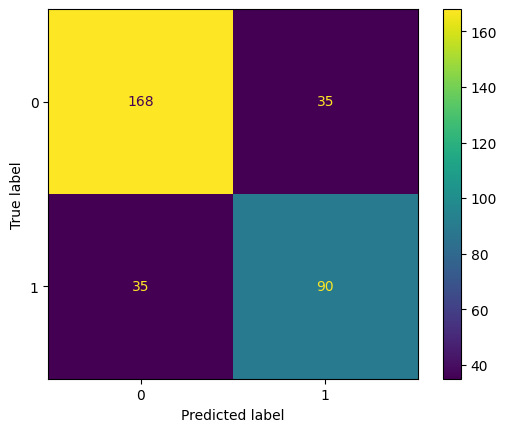

In [ ]:
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, (test_preds > 0.5).astype(int))
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(ax=ax)
plt.show()


## ROC Curve


By varying the threshold we use to classify items in a sample as positive or negative, we can see how the true positive rate and false positive rate change. We can improve the recall of our model at the cost of precision, or vice versa. The Receiver Operating Characteristic (ROC) curve is a useful tool for visualizing this tradeoff. It gets its name from the fact that it was first used in WW2 to study the performance of radar receivers at detecting Japanese aircraft.

The ROC curve plots the TPR against FPR at various threshold values. In other words, it shows the performance of a model across classification thresholds.


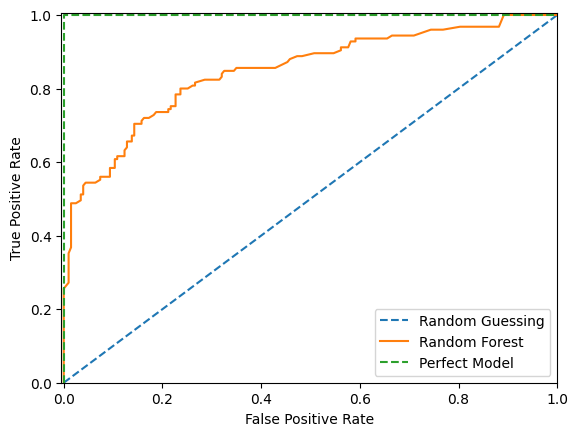

In [ ]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], "--", label="Random Guessing")
fpr, tpr, _ = roc_curve(y_test, test_preds)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label="Random Forest")
ax.plot([0, 0, 1], [0, 1, 1], "--", label="Perfect Model")
ax.set_xlim(-0.005, 1), ax.set_ylim(0, 1.005)
plt.legend()
plt.show()


As we can see above, with random guessing any attempt to increase our true positive rate will increase our false postitive rate by an equal amount. With a theoritically perfect model we have a 100% true positive rate and 0% false positive rate straight away. With our example model we can increase our true positive rate more quickly than the false positive rate up to a point before after which the false positive rate increases more quickly.

We would probably choose a threshold that puts our model as close to the upper left hand corner as possible. However there are times where we might not. For instance if a false postive would be more costly than a false negative we would want to choose a threshold that gives us a lower false positive rate at the cost of a higher false negative rate.


### ROC AUC Score


Of course we would prefer to not make that trade off and instead push the entire curve towards the upper left hand corner. To do that we would train a different model. To quantify how well different models are doing we can calculate the area underneath the ROC curve. This is called the ROC AUC score. The higher the score the better the model. A score of 0.5 means the model is no better than random guessing. A score of 1.0 means the model is perfect.


In [ ]:
print(f"ROC AUC score: {roc_auc_score(y_test, test_preds):.3f}")


ROC AUC score: 0.847


An interesting feature of the ROC AUC Score is that the score for a set can be larger than the score for any subset of that set. We can see this by considering an alternative definition for the ROC AUC Score which is the probability that a randomly chosen row with a postive $y$ value has a higher predicted probability than a randomly chosen row with a negative $y$ value. Mathemically, the AUC formula can be written as follows:

$$
AUC = \frac{\sum_{i=1}^{q}\sum_{j=1}^{q}I[y_i < y_j]I'[a_i < a_j]}{\sum_{i=1}^{q}\sum_{j=1}^{q}I[y_i < y_j]}
$$

where

$$
I'[a_i < a_j] =
\begin{cases}
    0 & a_i > a_j \\
    0.5 & a_i = a_j \\
    1 & a_i < a_j
\end{cases}
$$

and

$$
I[y_i < y_j] =
\begin{cases}
    0 & y_i \geq y_j \\
    1 & y_i < y_j
\end{cases}
$$

and

$a_i$ = the predicted probability for row $i$ \
$y_i$ = the true value for row $i$ \
$q$ = the number of rows in the set

For example, consider the following data, sorted by predicted probability:

| pred |  y  |
| :--: | :-: |
| 0.09 |  0  |
| 0.5  |  1  |
| 0.7  |  0  |

Here we have one correctly sorted pair of rows and one incorrectly sorted pair of rows. The probability that a randomly chosen row with a positive y value has a higher predicted probability than a randomly chosen row with a negative y value is therefore 0.5.

$$AUC = \frac{1}{2}\times\frac{1}{2} + \frac{1}{2}\times\frac{1}{2} = \frac{1}{2}$$

The AUC for this data will be 0.5.

Now consider this data:

| pred  |  y  |
| :---: | :-: |
| 0.095 |  0  |
| 0.41  |  1  |
| 0.42  |  0  |

Again the AUC for this data will be 0.5.

However let us now combine the two data sets:

| pred  |  y  |
| :---: | :-: |
| 0.09  |  0  |
| 0.095 |  0  |
| 0.41  |  1  |
| 0.42  |  0  |
|  0.5  |  1  |
|  0.7  |  0  |

$$AUC = \frac{1}{2}\times\frac{1}{2} + \frac{3}{4}\times\frac{1}{2} = 0.625$$


## Gini


The Gini Coefficient is the summary statistic of the Cumulative Accuracy Profile (CAP) chart. It is calculated as the quotient of the area which the CAP curve and diagonal enclose and the corresponding area in an ideal rating procedure.


In [ ]:
random_model_coords = [0, len(y_test)], [0, np.sum(y_test)]
rf_model_coords = (
    np.arange(0, len(y_test) + 1),
    np.append([0], np.cumsum([y for _, y in sorted(zip(test_preds, y_test), reverse=True)])),
)
perfect_model_coords = ([0, np.sum(y_test), len(y_test)], [0, np.sum(y_test), np.sum(y_test)])


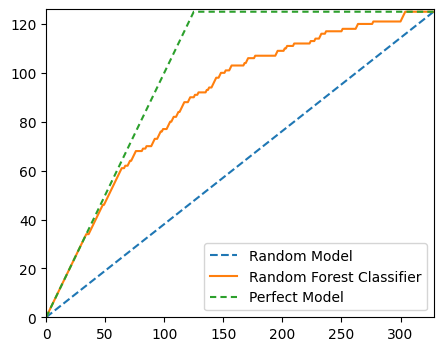

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(*random_model_coords, linestyle="--", label="Random Model")
ax.plot(*rf_model_coords, linestyle="-", label="Random Forest Classifier")
ax.plot(*perfect_model_coords, linestyle=(0, (3, 2)), label="Perfect Model")
ax.set_xlim(0, len(y_test))
ax.set_ylim(0, np.sum(y_test) + 1)
plt.legend()
plt.show()


In [ ]:
# Area under Random Model
aR = auc(*random_model_coords)
# Area under Random Forest Model
a = auc(*rf_model_coords)
# Area under Perfect Model
aP = auc(*perfect_model_coords)

aR, a, aP


(20500.0, 29343.5, 33187.5)

In [ ]:
# Area between Perfect and Random Model
aP - aR


12687.5

In [ ]:
# Area between Random Forest and Random Model
a - aR


8843.5

In [ ]:
# Accuracy rate
accuracy_rate = (a - aR) / (aP - aR)
accuracy_rate


0.6970246305418719

The accuracy rate is the same as the Gini. The direct conversion between accuracy rate / Gini and AUC_ROC is:

$$Gini = 2AUC\_ROC - 1$$


We can derive the above formula like so:

Let $aP$ be the area under a perfect model curve

Let $a$ be the area under a trained model curve

Let $aR$ be the area under a random model curve

$$
\begin{align}
\text{Gini} &= \frac{a - aR}{aP - aR} \\
aP - aR &= \frac{1}{2} \\
\text{Gini} &= \frac{a - aR}{\frac{1}{2}} \\
&= 2(a - aR) \\
AUC &= (a - aR) + \frac{1}{2} \\
a - aR &= AUC - \frac{1}{2} \\
\text{Gini} &= 2(AUC - \frac{1}{2}) \\
&= 2AUC - 1 \\
\end{align}
$$


In [ ]:
2 * roc_auc_score(y_test, test_preds) - 1


0.6938719211822659

The results are slightly different results because the AUC is calculated using the trapezium method which is only an approximation of the true area under the curve.


## Precision-Recall Curve


The precision-recall curve shows the tradeoff between precision and recall for different thresholds. As you increase the threshold, you increase the precision since the model is only returning positive predictions when it is very confident but you decrease the recall since fewer true positives will meet the threshold.

High scores for both precision and recall show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). So we would like to maximise the area under this curve.

The precision-recall curve can be more informative than the ROC curve when dealing with imbalanced data. See more [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/). PR plots won't let a model get away with just predicting the majority class.


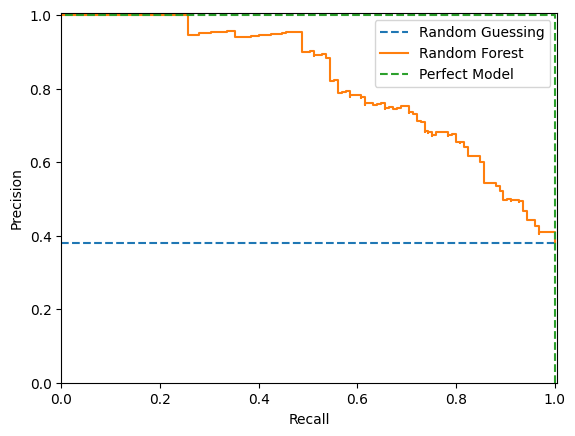

In [ ]:
fig, ax = plt.subplots()
ax.plot([0, 1], [y_test.mean(), y_test.mean()], "--", label="Random Guessing")
precision, recall, thresholds = precision_recall_curve(y_test, test_preds)
PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax, label="Random Forest")
ax.plot([1, 1, 0], [0, 1, 1], "--", label="Perfect Model")
ax.set_xlim(0, 1.005), ax.set_ylim(0, 1.005)
plt.legend()
plt.show()


In the above example a random model would produce a horizontal line at the mean the mean of the true values.

We can use the trapezium rule to find the area under the precision-recall curve:


In [ ]:
-np.sum(np.diff(recall) * np.array(precision)[:-1])


0.8198678510173409

In scikit-learn this formula is known as the `average_precision_score`:


In [ ]:
average_precision_score(y_test, test_preds)


0.8198678510173409

## Sources


- https://www.toyota-ti.ac.jp/Lab/Denshi/COIN/people/yutaka.sasaki/F-measure-YS-26Oct07.pdf
- https://stats.stackexchange.com/questions/416901/can-the-roc-auc-of-a-total-test-set-be-larger-than-the-auc-for-any-subset-of-som
- https://dasha.ai/en-us/blog/auc-roc#:~:text=ROC%20AUC%20is%20the%20area,%3D%209.5%2F12%20~%200.79.
- https://www.kaggle.com/code/rohandawar/cap-cumulative-accuracy-profile-analysis-1
- https://www.geeksforgeeks.org/python-cap-cumulative-accuracy-profile-analysis/
- https://www.listendata.com/2019/09/gini-cumulative-accuracy-profile-auc.html
